In [1]:
! pip install import-ipynb
! pip install scikit-learn

In [2]:
import pandas as pd
import import_ipynb
from create_pswm import get_pswm
import math
import numpy as np
import seaborn as sns
import sklearn.metrics as skl
from sklearn.metrics import precision_recall_curve

In [3]:
def algorithm_vonheijne(matrix , df_val): 
    
    # iterate among all sequences in the validation set. 
    
    validation_complete = [] #list that contains all the scores as well as additional informations
    validation_scores = [] #list that only contains the scores
    
    for _ , row in df_val.iterrows():

        seq = row["Sequence"] #extract the sequence from the dataframe
        pos = 0 # counter for window size tracking
        aa = 0 # index that moves along the sequence
        tmp_score = 0 #inizialise window score
        max_window_score = -math.inf , 0 , 0 , "seq" # initialize a variable that keeps in memory only the best window 
        
        end = min(90, len(seq)) # we end iterating on the sequence when we reach the 90th aa or when the sequence ends (sequence length < 90 aa)
        
        while aa < end - 14: # iteration on the sequence
            while pos <= 14: # iteration while the window is less than the fixed window size
                try: #try statement to handle aminoacids not found in the matrix
                    tmp_score += matrix[seq[aa + pos]][pos] # computing the score of the window
                except KeyError :
                    tmp_score += 0
                pos +=1 # increasing the window size counter
            if tmp_score > max_window_score[0]: # checking if the actual window has a better score than the previous one
                max_window_score = tmp_score, aa, aa + pos, seq[aa:aa + pos]
                
            aa += 1 # increase the starting point
            pos = 0 # resetting the window size

        validation_scores.append(max_window_score[0])
        validation_complete.append(max_window_score) 
    return validation_complete , validation_scores

In [4]:
def class_vector(df_obs): #function that creates a class vector for all the sequences in a dataset given the index
    class_list = []
    for _ , row in df_obs.iterrows():
        if row["Class"] == "Negative":
            class_list.append(0)
        else: #if row["Class"] == "Positive"
            class_list.append(1)
    return class_list

In [5]:
def best_threshold(validation_class , validation_scores , test_class , test_scores ): #secondo te cosa fa una funzione che si chiama best threshold? 

    # index --> index of the test set
    # validation_class --> classes observed in the validation set
    # validation_scores --> scores computed on the validation set

    #best_treshold --> best threshold according to the validation set
    
    # test_scores --> scores computed on the test set
    # test_class --> classes observed in the test set
    
    
    precision, recall, thresholds = precision_recall_curve(validation_class, validation_scores)
    f_score = np.divide(
        2 * precision * recall,
        precision + recall,
        out=np.zeros_like(precision, dtype=float),
        where=(precision + recall) != 0
        )
    index_th = np.argmax(f_score)
    best_threshold = thresholds[index_th]
    predicted_class = [int( score >= best_threshold) for score in test_scores]
    
    #return the list that contains the predicted classes of the test_set
    return predicted_class, precision, recall


In [6]:
def metrics(pswm, validation, test):

    obs_validation = class_vector(validation)
    val_scores , val_scores_only = algorithm_vonheijne(pswm, validation)  #validation scores and binary classification
    obs_test = class_vector(test)
    test_scores, test_scores_only = algorithm_vonheijne(pswm, test)   #test scores and binary classification
    predicted_class_test, precision, recall = best_threshold(obs_validation, val_scores_only, obs_test, test_scores_only)

    MCC = skl.matthews_corrcoef(obs_test, predicted_class_test)            # Matthews Correlation Coefficient
    ACC = skl.accuracy_score(obs_test, predicted_class_test)               # Accuracy
    PPV = skl.precision_score(obs_test, predicted_class_test)              # Precision
    SEN = skl.recall_score(obs_test, predicted_class_test)                      # Recall
    sns.lineplot( x=recall, y=precision) #Draw the precision recall curve
    return MCC, ACC, PPV, SEN 
    

MCC = 0.6083467619922756
Precision = 0.9282595134123518
Accuracy = 0.695364238410596
Sensitivity = 0.603448275862069




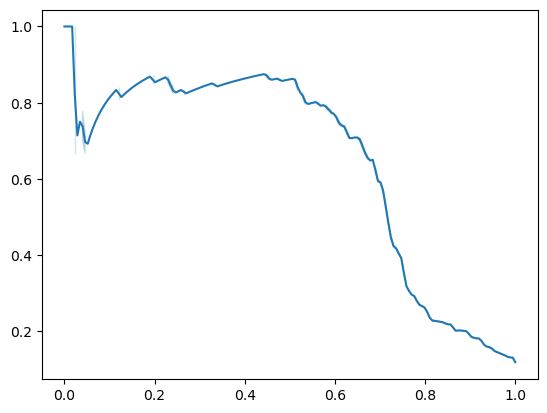

In [7]:
# TEST CELL : metrics
if __name__ == "__main__":
    metrics_name = ["MCC", "Precision", "Accuracy", "Sensitivity"]
    df=pd.read_csv("../Data_Preparation/train_bench.tsv", sep="\t")
    df_pos=df.query("Class=='Positive' and (Set=='1' or Set=='2' or Set=='3' or Set=='4' or Set=='5')") #recover a training set
    df_validation=df.query("Set=='1'") #recover a validation set
    df_test=df.query("Set=='2'") #recover a testing set
    matrix = get_pswm(df_pos,13,2) #recover the pswm matrix
    stats=metrics(matrix,df_validation,df_test)  #get the metrics

    for name, stat in zip(metrics_name,stats):
        print(f"{name} = {stat}")
    print("\n")
    
    
